In [1]:
import subprocess
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
RUN = 100

In [3]:
# get stdout from a terminal command
def get_stdout(command):
    return subprocess.check_output(command, shell=True).decode('utf-8')

POD_TO_NODE = {}
def get_node_of_pod(podname):
    if podname in POD_TO_NODE:
        return POD_TO_NODE[podname]
    else:
        node = get_stdout("kubectl get pod " + podname + 
                   " -o jsonpath='{.spec.nodeName}'")
        POD_TO_NODE[podname] = node
        return node

In [4]:
logfilename = f"none_CPU_{RUN}"

with open(logfilename) as f:
    lines = f.readlines()
    
rows = []    
    
for line in lines:
    
    line_json = json.loads(line.strip())
    
    cpu_util = line_json["CPUUtilizations"]
    for podname in cpu_util.keys():
        if podname == "utils":
            continue
        rows.append({
            "time": float(line_json["time"])/10**9,
            "podname": podname,
            "service": podname.split("-")[0],
            "node": get_node_of_pod(podname),
            "cpu": float(cpu_util[podname]),
        })
        
df = pd.DataFrame(rows)
df["time"] = df["time"] - df["time"].min()
# df = df[df["time"] <= 30]

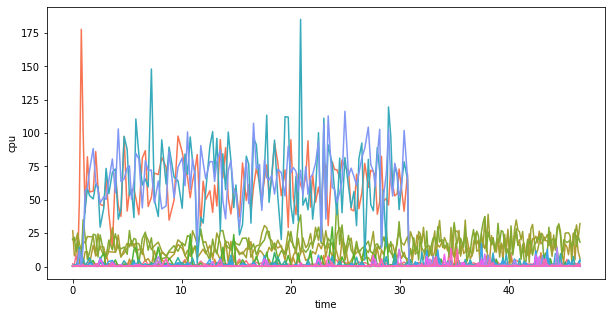

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

sns.lineplot(ax=ax, data=df, x="time", y="cpu", hue="podname")

#remove legend from ax
ax.get_legend().remove()

In [6]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 25)].groupby(["podname", "node"]).mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,node,time,cpu
15,profile-0,minikube-m02,14.698142,67.222854
12,mongodb-profile-0,minikube-m04,14.698142,65.164925
1,frontend-0,minikube-m02,14.698142,61.344918
6,hostagent-node3,minikube-m04,14.698142,16.844887
5,hostagent-node2,minikube-m03,14.698142,16.120780
4,hostagent-node1,minikube-m02,14.698142,10.695179
7,jaeger-0,minikube-m04,14.698142,3.247671
0,consul-0,minikube-m04,14.698142,2.306457
11,mongodb-geo-0,minikube-m04,14.698142,1.365739
14,mongodb-reservation-0,minikube-m02,14.698142,1.176323


In [7]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "node"]).mean().reset_index().groupby("node").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,node,time,cpu
0,minikube-m02,99.42642,141.672708
2,minikube-m04,115.99749,89.539178
1,minikube-m03,132.56856,20.414739


In [8]:
# group by podname
df_grouped = df[(df["time"] > 2) & (df["time"] < 2 + 28)].groupby(["podname", "service"]).mean().reset_index().groupby("service").sum().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,service,time,cpu
6,mongodb,66.28428,68.408241
7,profile,33.14214,68.060216
1,frontend,33.14214,61.797923
3,hostagent,49.71321,43.451297
4,jaeger,16.57107,3.343963
0,consul,16.57107,2.271057
5,memcached,49.71321,1.485943
9,reservation,16.57107,0.636267
11,user,16.57107,0.567224
10,search,16.57107,0.567149


In [9]:
df_grouped = df[df["time"] < 1].groupby("podname").mean().reset_index()
df_grouped = df_grouped.sort_values("cpu", ascending=False)
df_grouped

,podname,time,cpu
1,frontend-0,0.466646,47.345912
5,hostagent-node2,0.466646,19.018224
6,hostagent-node3,0.466646,16.807626
4,hostagent-node1,0.466646,11.928499
12,mongodb-profile-0,0.466646,5.799885
15,profile-0,0.466646,4.167104
0,consul-0,0.466646,3.058763
11,mongodb-geo-0,0.466646,1.814920
13,mongodb-rate-0,0.466646,0.958671
16,profile-1,0.466646,0.632378
